In [232]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os.path as osp
import sys

sys.path.insert(0, "/usr/users/vogg/FairMOT/own_ideas/")

In [233]:
sys.path

['/usr/users/vogg/FairMOT/own_ideas/',
 '/usr/users/vogg/FairMOT/own_ideas/',
 '/usr/users/vogg/FairMOT/own_ideas/',
 '/usr/users/vogg/FairMOT/own_ideas/',
 '/usr/users/vogg/FairMOT/DCNv2',
 '/usr/users/vogg/FairMOT/src/',
 '/usr/users/vogg/FairMOT/src/lib/',
 '/opt/conda/envs/FairMOT/src/lib/',
 '/opt/conda/envs/FairMOT/src/',
 '/opt/conda/envs/FairMOT',
 '/opt/conda/envs/FairMOT/lib/python3.8/site-packages',
 '/usr/users/vogg/FairMOT/own_ideas',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/vogg/.ipython']

In [234]:
import logging
import os
import re
import motmetrics as mm
import matplotlib.pyplot as plt

from lib.opts import opts
from lib.tracking_utils.utils import mkdir_if_missing
from lib.tracking_utils.log import logger
import lib.datasets.dataset.jde as datasets
from track import eval_seq

In [235]:
os.getcwd()

'/usr/users/vogg/FairMOT/own_ideas'

In [236]:
def read_gt_results(filename):
    """
    Input: .txt or .csv file containing labeled from VoTT
    """
    results_dict = dict()
    if os.path.isfile(filename):
        fid = 0
        frid_prior = ""
        with open(filename, 'r') as f:
            next(f)
            for line in f.readlines():
                linelist = line.split(',')
                frid = linelist[0]
                if frid != frid_prior:
                    fid = fid + 2
                frid_prior = frid    
                    
                results_dict.setdefault(fid, list())
                
                #convert xmin, ymin, xmax, ymax to tlwh
                linelist[3] = float(linelist[3]) - float(linelist[1])
                linelist[4] = float(linelist[4]) - float(linelist[2])
                box_size = float(linelist[3]) * float(linelist[4])
                
                score = float(1)
                
                tlwh = tuple(map(float, linelist[1:5]))
                target_id = int(linelist[5].split('"')[1])
                results_dict[fid].append((tlwh, target_id, score))

    return results_dict

gt_results = read_gt_results("/usr/users/vogg/test/Validation-export.csv")
#gt_results[4]

In [237]:
#Models
# Train mcqpose only
# Train OMS only
# Train OMS + Mcqpose
# Train Mcqpose + OMS
#mcqpose_ft_dla34.pth
#oms_ft_dla34.pth

#conf_thres

In [144]:
!python ../src/demo.py mot --load_model ../models/oms/oms10.pth \
    --input-video ../../test/VID_20210223_123551.mp4 --output-root ../videos/oms10 \
    --conf_thres 0.4

Traceback (most recent call last):
  File "../src/demo.py", line 11, in <module>
    from tracking_utils.utils import mkdir_if_missing
  File "/usr/users/vogg/FairMOT/src/lib/tracking_utils/utils.py", line 7, in <module>
    import cv2
ModuleNotFoundError: No module named 'cv2'


In [238]:
def read_mot_results(filename):
    results_dict = dict()
    if os.path.isfile(filename):
        with open(filename, 'r') as f:
            for line in f.readlines():
                linelist = line.split(',')
                fid = int(linelist[0])
                if fid < 1:
                    continue
                results_dict.setdefault(fid, list())

                box_size = float(linelist[4]) * float(linelist[5])
                
                score = float(linelist[6])

                tlwh = tuple(map(float, linelist[2:6]))
                target_id = int(linelist[1])

                results_dict[fid].append((tlwh, target_id, score))

    return results_dict

In [240]:
models = ['mcq'+ str(elem) for elem in list(range(10,121,10))] + \
['oms' + str(elem) for elem in [2,6]] + \
['mcq' + str(elem) + 'oms2' for elem in list(range(10,121,10))]

models

['mcq10',
 'mcq20',
 'mcq30',
 'mcq40',
 'mcq50',
 'mcq60',
 'mcq70',
 'mcq80',
 'mcq90',
 'mcq100',
 'mcq110',
 'mcq120',
 'oms2',
 'oms6',
 'mcq10oms2',
 'mcq20oms2',
 'mcq30oms2',
 'mcq40oms2',
 'mcq50oms2',
 'mcq60oms2',
 'mcq70oms2',
 'mcq80oms2',
 'mcq90oms2',
 'mcq100oms2',
 'mcq110oms2',
 'mcq120oms2']

In [241]:
accs = []

for i in models:
    print(i)
    results = read_mot_results("/usr/users/vogg/FairMOT/videos/" + i + "/results.txt")
    #get every second frame to compare to labeled video
    mot_results = { your_key: results.get(your_key, results.get(your_key + 1))
                   for your_key in range(2,330,2) }
    print(len(mot_results))

    acc = mm.MOTAccumulator(auto_id = True)

    for frame_id in range(2, 330, 2):

        gt_objs = gt_results.get(frame_id, [])
        gt_tlwhs, gt_ids, _ = zip(*gt_objs)

        trk_objs = mot_results.get(frame_id, [])
        trk_tlwhs, trk_ids, _ = zip(*trk_objs)

        iou_distance = mm.distances.iou_matrix(gt_tlwhs, trk_tlwhs, max_iou=0.5)
        acc.update(gt_ids, trk_ids, iou_distance)

        metrics=('mota', 'num_switches', 'idp', 'idr', 'idf1', 'precision', 'recall')
        mh = mm.metrics.create()

    accs.append(acc)

mcq10
164
mcq20
164
mcq30
164
mcq40
164
mcq50
164
mcq60
164
mcq70
164
mcq80
164
mcq90
164
mcq100
164
mcq110
164
mcq120
164
oms2
164
oms6
164
mcq10oms2
164
mcq20oms2
164
mcq30oms2
164
mcq40oms2
164
mcq50oms2
164
mcq60oms2
164
mcq70oms2
164
mcq80oms2
164
mcq90oms2
164
mcq100oms2
164
mcq110oms2
164
mcq120oms2
164


In [242]:
summary = mh.compute_many(
            accs,
            metrics=metrics,
            names=models,
            generate_overall=True
        )

summary

,mota,num_switches,idp,idr,idf1,precision,recall
mcq10,0.381161,26,0.671371,0.364732,0.472676,0.877016,0.476451
mcq20,0.484118,17,0.679466,0.445783,0.538360,0.883139,0.579409
mcq30,0.534502,28,0.645533,0.490690,0.557561,0.871758,0.662651
mcq40,0.568456,30,0.670922,0.518072,0.584672,0.889362,0.686747
mcq50,0.542169,31,0.631054,0.485214,0.548607,0.874644,0.672508
mcq60,0.570646,27,0.663488,0.533406,0.591378,0.873297,0.702081
mcq70,0.548740,24,0.642553,0.496166,0.559951,0.872340,0.673604
mcq80,0.524644,43,0.620056,0.480832,0.541641,0.868644,0.673604
mcq90,0.572837,25,0.675000,0.532311,0.595224,0.880556,0.694414
mcq100,0.576123,28,0.694293,0.559693,0.619770,0.876359,0.706462


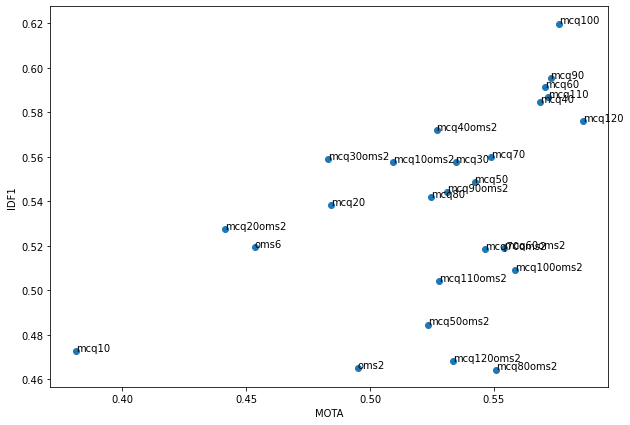

In [252]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(summary.mota[:-1], summary.idf1[:-1])
ax.set_xlabel("MOTA")
ax.set_ylabel("IDF1")

for i, txt in enumerate(summary.index[:-1]):
    ax.annotate(txt, (summary.mota[i], summary.idf1[i]))

In [125]:
summary.index

Index(['m20', 'm30', 'm40', 'm50', 'm60', 'm70', 'm80', 'm90', 'm100', 'm110',
       'm120', 'oms2', 'oms6', 'OVERALL'],
      dtype='object')